In [1]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [12]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
df = pd.read_csv(r'..\data\processed\combined_metab_lipid_table.csv', index_col=0)
data_cols = df.filter(regex='FBG|RBG').columns
pval_cols = df.filter(regex='pval').columns

In [8]:
lme = pd.read_csv(r'..\data\interim\mutliomics_lme_models_results.csv', index_col=0)

In [55]:
lme.loc[(lme['no_feeding_fdr_pval'] < 0.05) & (lme.index.str.contains('l'))]

,no_gluc_tol_pval,no_feeding_pval,no_cross_pval,no_gluc_tol_fdr_pval,no_feeding_fdr_pval,no_cross_fdr_pval,full_model_converged,no_gluc_tol_converged,no_feeding_converged,no_cross_converged,...,no_gluc_tol_params,no_feeding_params,no_cross_params,full_model_aic,no_gluc_tol_aic,no_feeding_aic,no_cross_aic,delta_aic_full_no_gluc,delta_aic_full_no_feeding,delta_aic_full_no_cross
feature_name,,,,,,,,,,,,,,,,,,,,,
l_51,0.304633,9.748068e-12,0.247907,0.462838,5.831975e-11,0.455506,True,True,True,True,...,"{'Intercept': 19.20634303844025, 'bg_type[T.RB...","{'Intercept': 18.59233430984124, 'glucose_tole...","{'Intercept': 19.39795154126868, 'glucose_tole...",141.130439,137.965602,189.416909,139.919843,3.164837,-48.286470,1.210596
l_59,0.118371,4.655621e-03,0.755626,0.251079,8.833101e-03,0.855025,True,True,True,True,...,"{'Intercept': 25.443702685281938, 'bg_type[T.R...","{'Intercept': 25.492313237255658, 'glucose_tol...","{'Intercept': 25.196160418420856, 'glucose_tol...",127.813972,127.166927,134.805197,124.374389,0.647045,-6.991225,3.439583
l_62,0.276266,1.791246e-06,0.638191,0.438224,5.231529e-06,0.776570,True,True,True,True,...,"{'Intercept': 21.62992609422642, 'bg_type[T.RB...","{'Intercept': 22.050996610233547, 'glucose_tol...","{'Intercept': 21.438471623221243, 'glucose_tol...",156.240982,153.350277,179.702403,153.139217,2.890705,-23.461421,3.101765
l_64,0.488027,1.866367e-13,0.657003,0.624574,1.460158e-12,0.786662,True,True,True,True,...,"{'Intercept': 22.359037740914733, 'bg_type[T.R...","{'Intercept': 23.180455182619312, 'glucose_tol...","{'Intercept': 22.274534628656067, 'glucose_tol...",138.754084,134.187808,195.085540,135.594216,4.566276,-56.331456,3.159868
l_65,0.005421,1.480167e-26,0.011859,0.029293,1.599505e-24,0.052844,True,True,True,True,...,"{'Intercept': 20.527910002058906, 'bg_type[T.R...","{'Intercept': 19.094377555557216, 'glucose_tol...","{'Intercept': 20.550588275672137, 'glucose_tol...",117.793828,124.470297,235.123244,122.663231,-6.676469,-117.329416,-4.869403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_1023,0.003342,2.693715e-04,0.000406,0.021378,6.251588e-04,0.005396,True,True,True,True,...,"{'Intercept': 18.471800602745553, 'bg_type[T.R...","{'Intercept': 18.8766432253355, 'glucose_toler...","{'Intercept': 18.57058789690177, 'glucose_tole...",199.867469,207.638638,212.898639,211.487349,-7.771169,-13.031170,-11.619880
l_1024,0.000256,1.889936e-11,NaN,0.004384,1.075559e-10,NaN,True,True,True,False,...,"{'Intercept': 19.713010524505968, 'bg_type[T.R...","{'Intercept': 19.240441840242855, 'glucose_tol...","{'Intercept': 19.952189857768406, 'glucose_tol...",143.702391,157.172060,190.640481,158.772396,-13.469669,-46.938090,-15.070005
l_1025,0.003903,5.037700e-05,NaN,0.023844,1.251463e-04,NaN,True,True,True,False,...,"{'Intercept': 17.91711518587462, 'bg_type[T.RB...","{'Intercept': 18.483154595823727, 'glucose_tol...","{'Intercept': 18.055975610736574, 'glucose_tol...",191.563111,198.984316,208.102197,202.388645,-7.421205,-16.539086,-10.825534


In [13]:
df

,Type,i,Proposed ID,Tracefinder ID,Lipid Class,m/z,RT [min],Area (Max.),Score,Adduct,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
Unique ID,,,,,,,,,,,,,,,,,,,,,
unknown_141.01586_16.616,metabolite,m_0,unknown,NaN,NaN,141.01586,16.616,31.253941,NaN,[M-H]-1,...,30.682774,30.713015,30.636650,30.699123,30.766149,30.497881,30.660280,30.612707,30.631697,30.794926
Linoleic Acid_279.23234_1.591,metabolite,m_1,Linoleic Acid,NaN,NaN,279.23234,1.591,30.736789,99.2,[M-H]-1,...,30.124329,29.724060,30.109212,30.203473,29.407519,30.130298,29.755386,29.830917,29.260529,29.010637
unknown_496.33981_2.597,metabolite,m_2,unknown,NaN,NaN,496.33981,2.597,30.704673,NaN,[M+H]+1,...,29.577390,29.910002,30.189935,29.744298,29.968890,29.847046,29.784137,29.933457,29.709495,29.593597
trans-Petroselinic acid_281.24793_1.568,metabolite,m_3,trans-Petroselinic acid,NaN,NaN,281.24793,1.568,30.641931,100.0,[M-H]-1,...,30.315600,29.119540,29.492769,29.923218,28.537792,30.129041,29.130426,29.104520,28.779871,28.319689
Uric acid_167.02007_12.732,metabolite,m_4,Uric acid,NaN,NaN,167.02007,12.732,30.533544,88.4,[M-H]-1,...,22.471185,17.976800,26.822243,26.471452,24.519750,24.755634,27.438915,25.684321,17.121551,24.795886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unknown_897.82532_20.148,lipid,l_1024,unknown,NaN,unknown,897.82532,20.148,21.562814,NaN,NaN,...,18.604841,18.755897,18.996482,20.095162,17.759520,18.908638,18.093365,17.607114,17.326455,16.927718
unknown_974.9118_20.163,lipid,l_1025,unknown,NaN,unknown,974.91180,20.163,22.106402,NaN,NaN,...,16.326408,19.046476,18.653201,18.635659,17.382575,17.575165,18.798950,16.704255,18.420810,17.646532
unknown_593.58716_20.175,lipid,l_1026,unknown,NaN,unknown,593.58716,20.175,21.652712,NaN,NaN,...,18.815858,18.693961,18.778798,20.192346,17.113028,18.925197,17.773412,17.541022,16.974304,16.687194


In [11]:
# feat = 'unknown_108179688_13387'
feature = "l_218"
def get_lme_params(feature, lme_df):
    """
    Return the three points that define each of Random and Fasted best fit lines for plotting in plt.scatter()
    in the form {'RBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]],
                 'FBG': [[normal_x, impaired_x, diabetic_x], [normal_y, impaired_y, diabetic_y]]}
    """
    # ast = Abstract Syntax Tree
    # This trick reads in an incorrectly formatted dictionary 
    # https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
    params = ast.literal_eval(lme_df.loc[feature]['full_model_params'])
    
    diabetic_fbg = params['Intercept']
    diabetic_rbg = params['Intercept'] + params['bg_type[T.RBG]']

    impaired_fbg = diabetic_fbg + params['glucose_tolerance[T.impaired]']
    impaired_rbg = diabetic_rbg + params['glucose_tolerance[T.impaired]'] + params['glucose_tolerance[T.impaired]:bg_type[T.RBG]']

    normal_fbg = diabetic_fbg + params['glucose_tolerance[T.normal]']
    normal_rbg = diabetic_rbg + params['glucose_tolerance[T.normal]'] + params['glucose_tolerance[T.normal]:bg_type[T.RBG]']
    
    return {'RBG': [[0, 1, 2], [normal_rbg, impaired_rbg, diabetic_rbg]],
            'FBG': [[0, 1, 2], [normal_fbg, impaired_fbg, diabetic_fbg]]}  
get_lme_params(feature, lme)

{'RBG': [[0, 1, 2], [21.92747466973287, 22.09723393432164, 22.10521169775811]],
 'FBG': [[0, 1, 2],
  [20.54578584692272, 20.502802006749533, 20.474755542989516]]}

In [30]:
# feat = conv_full_gluc_cross.sort_values('no_gluc_tol_pval').index[15]
# feat = 'TG_160_226_226_97372504_1493'
# feat = 'PlasmenylPE_P181_226_77252948_8781'
# feat = 'SM_d371_74562457_9972'
# feat = 'unknown_108179688_13387'
# feat = 'unknown_91372266_15818'
# feat = 'PlasmenylPE_P181_226_77253076_8913'
feat = 'l_218'

def make_lme_plot(feature):
    fig, ax = plt.subplots()
    fig.set_size_inches((7, 5))
    for gluc_tol in ['normal', 'impaired', 'diabetic']:
        for bg_type in ['RBG', 'FBG']:
            files = fg[(fg['bg_type'] == bg_type) & \
                       (fg['glucose_tolerance'] == gluc_tol) & \
                       (fg['quant_file'])]['combined_col_name']
            data = df.loc[df['i'] == feature, files]
            offset = (-0.05 if bg_type == 'RBG' else 0.05)
            if gluc_tol == 'normal':
                gluc_tol_x = 0
            elif gluc_tol == 'impaired':
                gluc_tol_x = 1
            else:
                gluc_tol_x = 2
            x = [gluc_tol_x + offset]*data.shape[1]
    #         display(data)
    #         display(x)
            ax.scatter(x, data, c=('blue' if bg_type == 'RBG' else 'darkorange'), s=80)
    # Plot fitted lines
    params = get_lme_params(feature, lme)
    plt.plot([x - 0.05 for x in params['RBG'][0]], params['RBG'][1], c='blue', label='Random-fed')
    plt.plot([x + 0.05 for x in params['FBG'][0]], params['FBG'][1], c='orange', label='Fasted')
    ax.set_title(feature, fontsize=16)  # + '\nOrange = Random\nBlue = Fasted')
    ax.set_xlabel('Glucose Tolerance', fontsize=17)
    ax.set_ylabel('log2 quant', fontsize=14)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['normal', 'impaired', 'diabetic'], fontsize=12)
    plt.legend(loc='upper left', fontsize=14)
    # plt.savefig(r'..\reports\figures\1-6-1\LME_Random_vs_Fasted_PC_180_204_81060138_9509_ex1.svg')  

Text(0.5, 1.0, 'unknown_601.51953_7.719\np-value effect of sampling = 1.2e-21\np-value effect of interaction = 0.75')

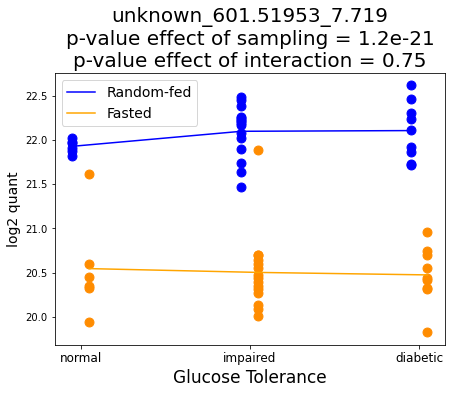

In [48]:
make_lme_plot('l_218')
plt.title('unknown_601.51953_7.719\np-value effect of sampling = 1.2e-21\np-value effect of interaction = 0.75',
          fontsize=20)

Text(0.5, 1.0, 'unknown_314.12727_9.512\np-value effect of sampling = 2e-18\np-value effect of interaction = 0.0015')

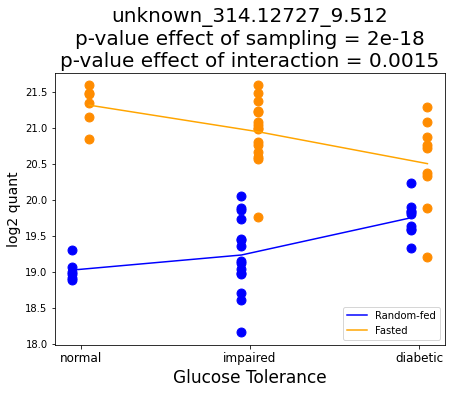

In [50]:
make_lme_plot('m_624')
plt.legend(loc='lower right')
plt.title('unknown_314.12727_9.512\np-value effect of sampling = 2e-18\np-value effect of interaction = 0.0015',
         fontsize=20)

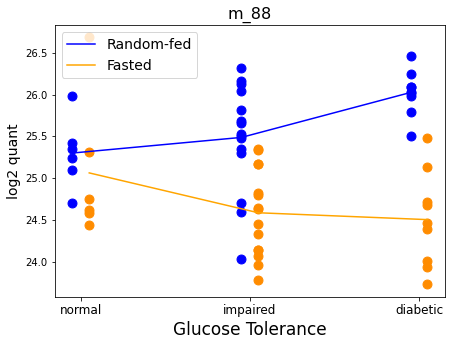

In [51]:

make_lme_plot('m_88')
# plt.legend(loc='lower right')
# plt.title('unknown_314.12727_9.512\np-value effect of sampling = 2e-18\np-value effect of interaction = 0.0015',
#          fontsize=20)